# Lab assignment №2: Gradient boosting and feature importance estimation

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Download it and place in `data/` folder in the same directory as this notebook. There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

There are several great frameworks (listed below). However, we recommend to stick to `LightGBM` for this task.
* LightGBM by Microsoft. [Link to github](https://github.com/Microsoft/LightGBM). It is one of the most popular frameworks these days that shows both great quality and performance.
* xgboost by dlmc. [Link to github](https://github.com/dmlc/xgboost). The most famous framework which got very popular on kaggle.
* Catboost by Yandex. [Link to github](https://github.com/catboost/catboost). Novel framework by Yandex company tuned to deal well with categorical features.

Some simple preprocessing is done for you. 

Parts 1 and 3 have the same weight equal to $1$. Part 2 has weight $0.5$.

### Part 1:
Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset:

* $\geq 90\%$ accuracy: 0.5 points for this part
* $\geq 92\%$ accuracy: 0.7 points for this part
* $\geq 94\%$ accuracy: 1 point for this part

In [1]:
import numpy as np

X_train = np.genfromtxt('data/train/X_train.txt')
y_train = np.genfromtxt('data/train/y_train.txt')

X_test = np.genfromtxt('data/test/X_test.txt')
y_test = np.genfromtxt('data/test/y_test.txt')

with open('data/activity_labels.txt', 'r') as iofile:
    activity_labels = iofile.readlines()

activity_labels = [x.replace('\n', '').split(' ') for x in activity_labels]
activity_labels = dict([(int(x[0]), x[1]) for x in activity_labels])

In [2]:
print(X_train.shape)
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean)/data_std
X_test = (X_test - data_mean)/data_std

(7352, 561)


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [3]:
try: 
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/basic_s20/homeworks_basic/Lab2_boosting/unique_columns.txt -nc
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)

X_train_unique = X_train[:, unique_columns]
X_test_unique = X_test[:, unique_columns]

PCA could be useful in this case. E.g.

In [4]:
from sklearn.decomposition import PCA

pca = PCA(0.99)

In [5]:
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

print(X_train_pca.shape)
print(X_test_pca.shape)

(7352, 179)
(2947, 179)


Text(0, 0.5, 'Principal component 5')

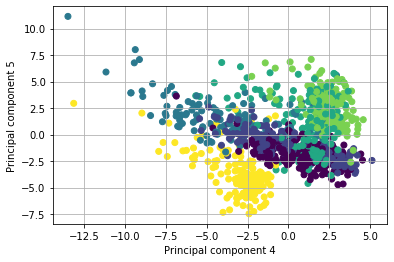

In [7]:
import matplotlib.pyplot as plt

plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 4')
plt.ylabel('Principal component 5')

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to use grid/random search (or any other approach) to approximate them by yourself.

Please try at least several models of different structure.

Provide the following to describe your path:

* Plot describing the model accuracy/precision/recall w.r.t. model complexity.
* ROC-AUC plot for the 3 best models you aquired (for multiclass case you might refer to the `scikit-plot` library.
* Small report describing your experiments.

[DART](https://arxiv.org/abs/1505.01866) might be useful as well in your experiments. It is available in [xgboost](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html) and [LightGBM](https://lightgbm.readthedocs.io/en/latest/Parameters.html), but seems [missing in CatBoost](https://github.com/catboost/catboost/issues/1006).

__Without the report and plots maximum score for this part of the lab is 0.3 of its full weight.__

In [101]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot
from tqdm.notebook import tqdm
from tqdm import tnrange
import seaborn as sns
import scipy.stats as sps
import pandas as pd


from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score

### Analytics

In [13]:
X = np.concatenate((X_test, X_train), axis=0)
y = np.concatenate((y_test, y_train), axis=0)

pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,-0.246388,-0.136979,1.668462,-0.742061,-0.814056,-0.150313,-0.759330,-0.819786,-0.164580,-0.781407,...,-0.213757,-0.072779,-0.262320,-0.006596,0.358560,-1.372126,0.579845,-0.450322,0.733571,-0.005244
1,0.164235,0.111059,-0.175548,-0.824544,-0.908299,-0.812607,-0.840212,-0.908595,-0.820280,-0.781407,...,-2.097734,0.576855,0.098679,-0.273719,0.034161,-0.728470,1.938673,-0.407493,0.748840,-0.098112
2,0.014187,-0.204740,-0.159111,-0.865561,-0.913208,-0.855099,-0.858146,-0.913397,-0.862926,-0.864367,...,-0.248637,0.363213,-0.050207,-0.129586,0.446413,0.091042,0.316041,-0.416639,0.744605,-0.081803
3,-0.059637,-0.365579,-0.147960,-0.867620,-0.919858,-0.865472,-0.860199,-0.921086,-0.876002,-0.863173,...,-0.034259,-0.116542,-0.360349,-0.076465,0.339639,0.544845,0.632687,-0.409180,0.758155,-0.073784
4,0.004908,-0.248785,-0.359980,-0.865636,-0.908274,-0.892234,-0.857457,-0.903555,-0.896405,-0.863173,...,-0.984174,-0.709294,-0.719531,-0.032386,-0.094211,1.196836,-0.235517,-0.396070,0.780371,-0.062135


В данных нет каегориальных фичей(полезное знание для выбора фраемворка для бустинга). Убедимся что в данных нет пропусков:

In [14]:
array_has_nan = np.isnan(X)

print(np.sum(array_has_nan.flatten())) # matrix to array cast

0


Визуализирум выборку с помощью PCA и посмотрим проекции на первую и вторую главные компоненты.

In [15]:
y2 = y
y2 = np.asarray(y2)
y2 = pd.DataFrame(y2)

for i in range(0, len(y2)):
    if(y2[0][i] == 1):
        y2[0][i] = 'Walking'
    elif(y2[0][i] == 2):
        y2[0][i] = 'Walking Upstairs'
    elif(y2[0][i] == 3):
        y2[0][i] = 'Walking Downstairs'
    elif(y2[0][i] == 4):
        y2[0][i] = 'Sitting'
    elif(y2[0][i] == 5):
        y2[0][i] = 'Standing'
    elif(y2[0][i] == 6):
        y2[0][i] = 'Laying'
        

pca = PCA(n_components=2)

pca.fit(X)

X_pca = pca.transform(X)
X_pca = pd.DataFrame(X_pca, columns = ['F1', 'F2'])

X_pca['label'] = y2[0]
X_pca.tail()

,F1,F2,label
10294,15.565185,-12.329009,Walking Upstairs
10295,14.296441,-10.022961,Walking Upstairs
10296,14.391554,-12.073046,Walking Upstairs
10297,12.946768,-13.907507,Walking Upstairs
10298,13.111363,-12.098503,Walking Upstairs


Text(37.31527777777778, 0.5, 'Проекция на вторую главную компоненту')

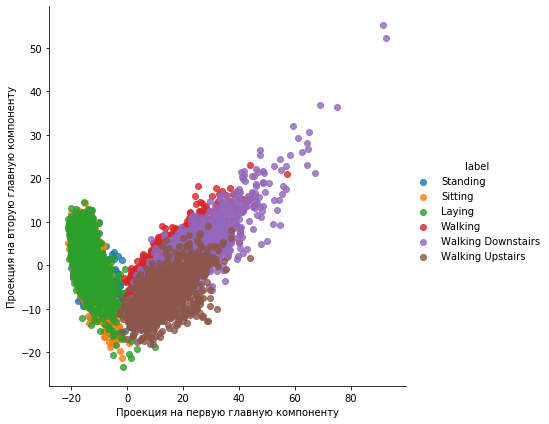

In [17]:
sns.lmplot(x = 'F1', y = 'F2', data = X_pca, hue = 'label',  fit_reg = False, x_jitter = 4.25, y_jitter = 2.4, size = 6)

plt.xlabel('Проекция на первую главную компоненту')
plt.ylabel('Проекция на вторую главную компоненту')

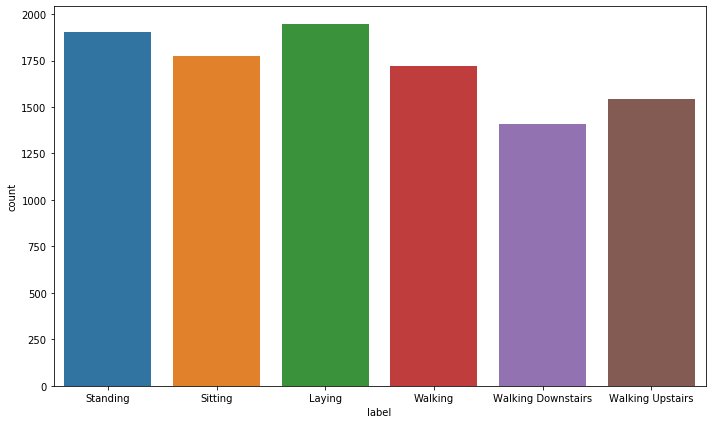

In [19]:
plt.figure(figsize = (10, 6))
sns.countplot(x = 'label', data = X_pca)
plt.tight_layout()

plt.show()

Видим что выборка неплохо сбалансирована (но мы все равно будем исопльзовать `StratifiedKFold`)

## xgboost

Посмотрим какая метрика получится если мы будем исопльзовать дефолтную модель

In [20]:
default_model = xgb.XGBClassifier()
default_model.fit(X_train, y_train)
y_pred_default = default_model.predict(X_test)
accuracy_score(y_test, y_pred_default)

0.9348489989820156

Начнем перебирать параметры по сетке. Во-первых, полный перебор по сетке работает слишком долго(было проверено). Во-вторых, при подборе более чем одного параметра рекомендуется использовать случайный поиск. Об этом можно найти в статье: http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf

Будем использовать рандомизированным поиск по сетке `RandomizedSearchCV`.

Для начала посмотрим какие параметры есть у xgboost.

In [22]:
xgb_model = xgb.XGBClassifier()
xgb_model.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [40]:
%%time
# выполняем поиск по сетке

xgb_search = RandomizedSearchCV(
    estimator=XGBClassifier(), 
    param_distributions={
        'max_depth': np.arange(3, 12), 
        'n_estimators': np.arange(50, 300, 15),
        'learning_rate': np.linspace(0.05, 0.7, 30),
    },
    scoring='accuracy',
    cv=5, 
    verbose=10,  # насколько часто печатать сообщения
    n_jobs=-1,  # параллелим
    n_iter=30  
)

xgb_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 39.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 52.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 61.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 70.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 80.0min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 86.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 104.0min finished


CPU times: user 2min 31s, sys: 707 ms, total: 2min 32s
Wall time: 1h 46min 34s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
       0.3862069 , 0.40862069, 0.43103448, 0.45344828, 0.47586207,
       0.49827586, 0.52068966, 0.54310345, 0.56551724, 0.58793103,
       0.61034483, 0.63275862, 0.65517241, 

Посомотрим на результаты (так как нас просили выбрать 3 лучших модели):

In [42]:
results_xgb = pd.DataFrame(xgb_search.cv_results_)
results_xgb.sort_values(by='rank_test_score', inplace=True)
results_xgb.head()[:3]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
29,228.180979,24.447288,0.145126,0.044145,185,3,0.363793,"{'n_estimators': 185, 'max_depth': 3, 'learnin...",0.925901,0.917063,0.923810,0.957823,0.957823,0.936484,0.017667,1
21,215.525307,14.200743,0.214512,0.021306,140,3,0.632759,"{'n_estimators': 140, 'max_depth': 3, 'learnin...",0.924541,0.915024,0.912245,0.956463,0.959864,0.933627,0.020473,2
14,412.029093,2.192416,0.273259,0.015002,260,4,0.543103,"{'n_estimators': 260, 'max_depth': 4, 'learnin...",0.920462,0.917063,0.910884,0.952381,0.957823,0.931723,0.019411,3


Сразу глянем метрику наилучшей модели

In [41]:
xgb_best_model = xgb_search.best_estimator_
xgb_best_model.fit(X_train, y_train)
y_pred_best = xgb_best_model.predict(X_test)
accuracy_score(y_test, y_pred_best)

0.9504580929759077

{'n_estimators': 185, 'max_depth': 3, 'learning_rate': 0.3637931034482758}
model: 0 accuracy: 0.9504580929759077
{'n_estimators': 140, 'max_depth': 3, 'learning_rate': 0.6327586206896552}
model: 1 accuracy: 0.9528333898880217
{'n_estimators': 260, 'max_depth': 4, 'learning_rate': 0.543103448275862}
model: 2 accuracy: 0.9497794367153037


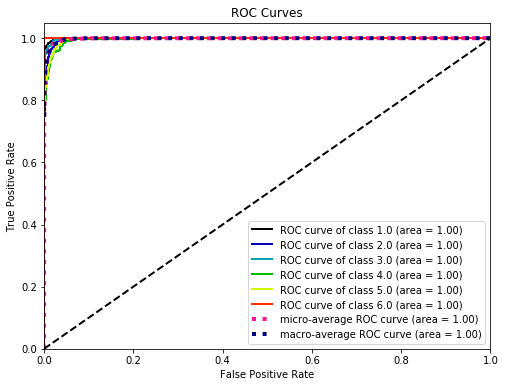

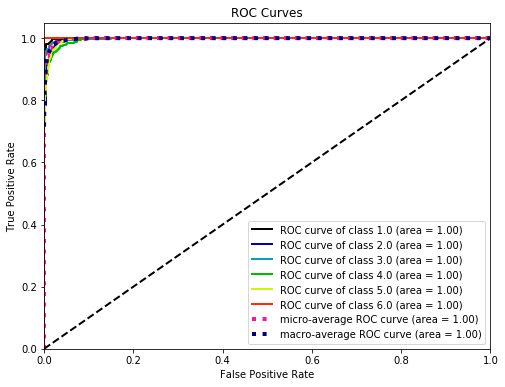

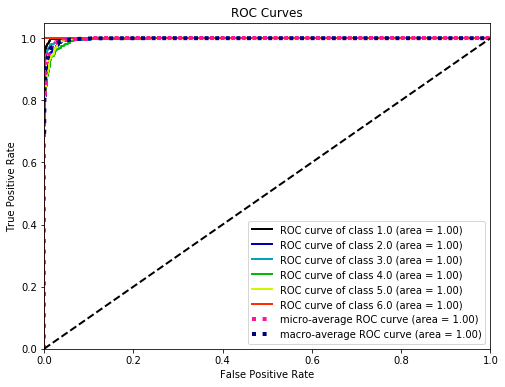

In [145]:
from scikitplot.metrics import plot_roc

head = results_xgb.head(3)

paramentrs_best_3_models = {}
for i in tqdm(range(3)): 
    p_i = head.loc[:, 'params'].iloc[i]
    
    rs_i = XGBClassifier(n_estimators = p_i['n_estimators'], 
                                max_depth = p_i['max_depth'], 
                         learning_rate = p_i['learning_rate'],
                         n_jobs = -1)
    
    rs_i.fit(X_train, y_train)
    
    paramentrs_best_3_models[i] = rs_i
    
    plot_roc(y_test, rs_i.predict_proba(X_test), figsize = (8, 6))
    plt.show()

    rs_i.fit(X_train, y_train)
    print('model: {} accuracy: {}'.format(i,accuracy_score(rs_i.predict(X_test), y_test)))

Не понял зачем просили строить `roc_auc`, но просто сделаем..

In [150]:
print(paramentrs_best_3_models)

{0: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3637931034482758, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=185, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1), 1: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.6327586206896552, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=140, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1), 2: XGBClassifier(base

In [ ]:
xgb_search.best_params_

Фиксируем найденные ранее оптимальные параметры, и варируя лишь один из них, посомтрим как это скажется на итоговом качестве модели. Построим графики.

In [103]:
n_estimators = xgb_search.best_params_['n_estimators']

accuracy_valid = [
    accuracy_score(
        y_test, xgb_search.best_estimator_.predict(X_test, 
                                               ntree_limit=i+1)
    )
    for i in tqdm(range(n_estimators))
]

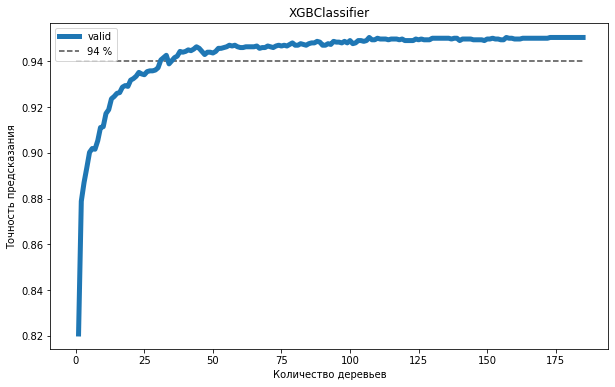

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(n_estimators) + 1, accuracy_valid, 
         lw=5, label='valid')
plt.hlines(0.94, 0, n_estimators, linestyles='--', 
           alpha=0.7, label='94 %')
plt.xlabel('Количество деревьев')
plt.ylabel('Точность предсказания')
plt.title('XGBClassifier')
plt.legend()
plt.show()

Видим что примерно до 50 качество модели довольно сильно растет, потом рост продолжает наблюдаться, но не значительно. Причем заметим что переобучения не происходит 

In [84]:
def fit_predict_metrics_calc(model_):
    model_.fit(X_train, y_train)
    
    return accuracy_score(y_test, model_.predict(X_test))

In [85]:
%%time

accuracy_valid_depth = list()
max_depth_range = np.linspace(1, 20, 13)

accuracy_valid_depth  = [
    fit_predict_metrics_calc(
             XGBClassifier(
                n_estimators = xgb_search.best_params_['n_estimators'],
                max_depth = int(max_depth),
                learning_rate = xgb_search.best_params_['learning_rate'],
                n_jobs = -1
        ))
    
    for max_depth in tqdm(max_depth_range)
]    
    



  0%|          | 0/13 [00:00<?, ?it/s]

  8%|▊         | 1/13 [01:46<21:19, 106.59s/it]

 15%|█▌        | 2/13 [04:10<21:34, 117.67s/it]

 23%|██▎       | 3/13 [06:49<21:42, 130.20s/it]

 31%|███       | 4/13 [09:30<20:53, 139.28s/it]

 38%|███▊      | 5/13 [12:07<19:18, 144.82s/it]

 46%|████▌     | 6/13 [14:51<17:33, 150.47s/it]

 54%|█████▍    | 7/13 [17:39<15:34, 155.75s/it]

 62%|██████▏   | 8/13 [20:30<13:21, 160.36s/it]

 69%|██████▉   | 9/13 [23:11<10:42, 160.65s/it]

 77%|███████▋  | 10/13 [26:05<08:13, 164.49s/it]

 85%|████████▍ | 11/13 [29:03<05:36, 168.47s/it]

 92%|█████████▏| 12/13 [31:39<02:44, 164.89s/it]

100%|██████████| 13/13 [34:17<00:00, 158.24s/it]

CPU times: user 33min 29s, sys: 8.55 s, total: 33min 38s
Wall time: 34min 17s


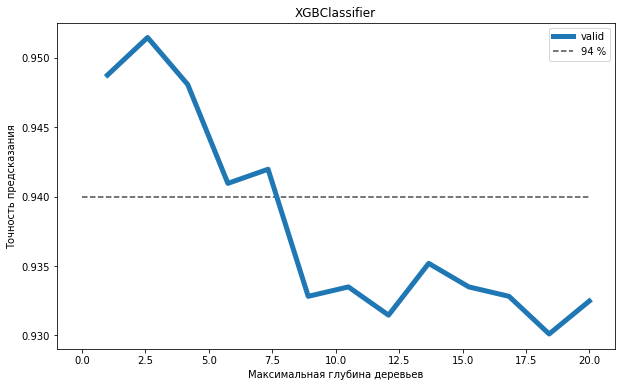

In [95]:
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, accuracy_valid_depth,
         lw=5, label='valid')
         
plt.hlines(0.94, 0, max(max_depth_range), linestyles='--', 
           alpha=0.7, label='94 %')
plt.xlabel('Максимальная глубина деревьев')
plt.ylabel('Точность предсказания')
plt.title('XGBClassifier')
plt.legend()
plt.show()

Видим что оптимальная глубина - 3, после этого происходит переобучение и качество на тесте начинает падать

In [87]:
%%time

learning_rate_range = np.linspace(0.05, xgb_search.best_params_['learning_rate'], 10)
accuracy_valid_lr = list()
   
accuracy_valid_lr  = [
    fit_predict_metrics_calc(
            XGBClassifier(
                n_estimators = xgb_search.best_params_['n_estimators'],
                max_depth = xgb_search.best_params_['max_depth'],
                learning_rate = learning_rate,
                n_jobs = -1
                )
             )
    
    for learning_rate in tqdm(learning_rate_range)
] 



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [03:48<34:13, 228.21s/it]

 20%|██        | 2/10 [07:24<29:58, 224.77s/it]

 30%|███       | 3/10 [10:46<25:23, 217.69s/it]

 40%|████      | 4/10 [13:57<20:58, 209.70s/it]

 50%|█████     | 5/10 [17:05<16:56, 203.22s/it]

 60%|██████    | 6/10 [20:05<13:05, 196.32s/it]

 70%|███████   | 7/10 [23:13<09:41, 193.75s/it]

 80%|████████  | 8/10 [26:36<06:32, 196.50s/it]

 90%|█████████ | 9/10 [29:14<03:05, 185.11s/it]

100%|██████████| 10/10 [31:45<00:00, 190.51s/it]

CPU times: user 30min 59s, sys: 6.09 s, total: 31min 5s
Wall time: 31min 45s


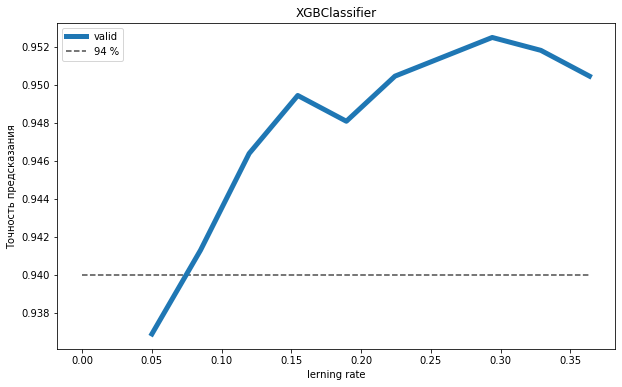

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(learning_rate_range, accuracy_valid_lr, 
         lw=5, label='valid')

plt.hlines(0.94, 0, max(learning_rate_range), linestyles='--', 
           alpha=0.7, label='94 %')
plt.xlabel('lerning rate')
plt.ylabel('Точность предсказания')
plt.title('XGBClassifier')
plt.legend()
plt.show()

**Вывод:** Воспользовавшись фреймворком xgboost и подобров оптимальные параметры с помощью `RandomizedSearchCV`, мы получили модель с accuracy > 0.95 на валидационной выборке. Посмотрели на зависимости `accuracy` от параметров: `learning_rate`, `n_estimators`, `max_depth`. 

Вообще существует несколько подходов в поиске оптимальных параметров в бустинге:
- GridSearch(как я понял очень редко используют)
- RandomizedSearchCV
- Эврестический (сначала выбиарем `learning_rate`, потом берем сетку `[n_estimators, max_depth]`. Это довольно эффективный способ, который используется на соревнованиях  
- Байесовская оптимизация (рассказывали на доп семинаре) 


_Возможно поиск по сетке стоило делать на GPU)_

Далее мы сравним наш `xgb_best_model` с другими базовыми моделями которые рассматривались в нашем курсе : 
- `KNN`
- `Logistic regression`
- `SVM`
- `Random forest`
- `Naive bayes`

### Part 2. Blending the models

Take three (or more) best models and try to build the blending ensemble of them. Compare the quality of the final model using the same quality measures as above.

#### Find optimal models

1. Выберем подходящие для наших данных модели
2. Подберем оптимальные параметры для них 
3. Применим stacking

In [104]:
from sklearn.ensemble import RandomForestClassifier

def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    models['forest'] = RandomForestClassifier()
    
    
    return models

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

model:lr score:0.9856272798974662 std: 0.002912)
model:knn score:0.9625490486049493 std: 0.007301)
model:svm score:0.9787807478063689 std: 0.004481)
model:bayes score:0.7315889652962633 std: 0.035520)
model:forest score:0.982090850833087 std: 0.005199)



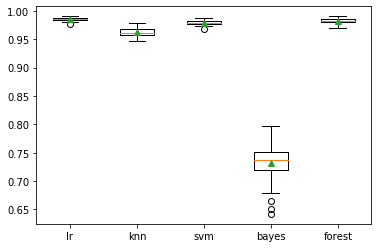

In [105]:
models = get_models()
results, names = list(), list()

for name, model in tqdm(models.items()):
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('model:{}  score:{}  std: {:2f})'.format(name, np.mean(scores), np.std(scores)))
    
    
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Самой _интересной_ моделью оказался `SVM`. Подберем оптимальные параметры и посчитаем метрику на валидации для следующих моделей: 
- SVM
- Random forest
- KNN

##### SVM

In [138]:
from sklearn import svm

svm_classifier=svm.SVC()

svm_grid=[
        {'kernel': ['rbf', 'linear'], 
          'gamma': [0.001, 0.0001], 
           'C': [1, 10, 100, 1000]}]

In [139]:
%%time

svm_search = GridSearchCV(svm_classifier, 
                          svm_grid, 
                          n_jobs=-1, 
                          cv=5, 
                          verbose=5)
svm_search.fit(X_train, y_train)

print('Best Parameters: '+ str(svm_search.best_params_))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   58.4s finished


Best Parameters: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
CPU times: user 3.44 s, sys: 92.7 ms, total: 3.53 s
Wall time: 1min 1s


In [136]:

svm_best_model = svm_search.best_estimator_

print('Accuracy Score: {}'.format(accuracy_score(y_test, svm_best_model.predict(X_test))))

Accuracy Score: 0.9613165931455717


##### Logistic regression

In [130]:
lr = LogisticRegression(solver='saga', multi_class='multinomial', 
                        max_iter= 2000, tol=1e-3)

params = {
    'penalty': ['l1', 'l2'],
    'C': np.linspace(-20, 20, 100)
}

logistic_search = RandomizedSearchCV(
                        lr, 
                        params, 
                        cv=StratifiedKFold(n_splits=2),
                        verbose=10,  # насколько часто печатать сообщения
                        n_jobs=-1,  # параллелим
                        n_iter=20 )

In [131]:
%%time

logistic_search.fit(X_train, y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:  2.2min remaining:   44.1s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:  3.0min remaining:   25.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.6min finished


CPU times: user 1min 43s, sys: 490 ms, total: 1min 43s
Wall time: 5min 19s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=2000,
                                                multi_class='multinomial',
                                                n_jobs=None, penalty='l2',
                                                random_state=None,
                                                solver='saga', tol=0.001,
                                                verbose=0, warm_start=False),...
        12.32323232,  12.72727273,  13.13131313,  13.53535354,
        13.93939394,  14.34343434,  14.74747475,  15.15151515,
        15.55555556,  15.95959596,  16.36363636,  16.76767677,
        17.171717

In [132]:
logistic_best_model = logistic_search.best_estimator_

print('Accuracy Score: {}'.format(accuracy_score(y_test, logistic_best_model.predict(X_test))))

Accuracy Score: 0.9474041398031897


##### Random forest

In [118]:
tree_gridsearch = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={
        'n_estimators': [10, 50, 75, 100], 
        'max_depth': [2, 5, None],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features':[11,7,9],
    }, 
    cv = 5
)

In [119]:
%%time

tree_gridsearch.fit(X_train, y_train)

CPU times: user 12min 47s, sys: 9.52 s, total: 12min 57s
Wall time: 13min 29s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [153]:
print(tree_gridsearch.best_params_)
rand_forest_best = tree_gridsearch.best_estimator_

{'max_depth': None, 'max_features': 9, 'min_samples_leaf': 1, 'n_estimators': 75}


In [121]:
print('test accuracy:', accuracy_score(tree_gridsearch.best_estimator_.predict(X_test), y_test))

test accuracy: 0.9355276552426196


##### KNN

In [113]:
knn = KNeighborsClassifier(n_neighbors = 24)
knn.fit(X_train, y_train)
ypred = knn.predict(X_test)

In [114]:
%%time

scores  = [
    fit_predict_metrics_calc(
            KNeighborsClassifier(n_neighbors = neighbor_cnt, n_jobs = -1)
             )
    
    for neighbor_cnt in tqdm(range(1,50))
] 


CPU times: user 15min 9s, sys: 1.71 s, total: 15min 10s
Wall time: 2min 23s


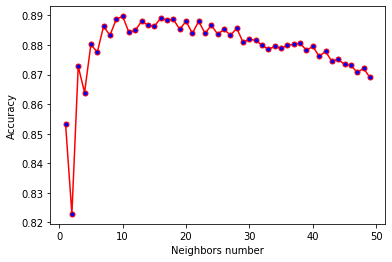

In [115]:
import matplotlib

plt.xlabel('Neighbors number')
plt.ylabel('Accuracy')

xticks = range(1,50)
plt.plot(xticks, scores, color='red', linestyle='solid', marker='o',
         markerfacecolor='blue', markersize=5)

In [143]:
knn_best_model = KNeighborsClassifier(n_neighbors= np.argmax(scores))
knn_best_model.fit(X_train, y_train)

print('test accuracy:', accuracy_score(knn_best_model.predict(X_test), y_test))

test accuracy: 0.8887003732609433


Тем временем, построим лидерборд рассмотренных моделей:

|Место  | Имя модели  | Точность на тесте|
|--|--| -- |
|  1| SVM | 0.961|
|  2| XGBClassifier |  0.950 |
| 3 |      LogisticRegrssion       | 0.947    |
|  4  | RandomForest|  0.936|
|  5  | KNN| 0.889 |

#### Stacking 

In [182]:
from sklearn.ensemble import StackingClassifier

# все рассмотренные ранее модели
estimators_all = [
*(('xbgoost{}'.format(i), paramentrs_best_3_models[i]) for i in range(3)), # три топовых бустинга
('SVM', svm_best_model),
('RandomForest', rand_forest_best),
('KNN', knn_best_model)
]

estimators_only_boosting = [
   *(('xbgoost{}'.format(i), paramentrs_best_3_models[i]) for i in range(3)) # три топовых бустинга
]

estimators_best_3model = [('xbgoost_best', xgb_best_model), 
                          ('svm', svm_best_model),
                          ('logistic regression', logistic_best_model)
                         ]

def fit_predict_score_stacking(name, estimators):
    stack = StackingClassifier(estimators, 
                               stack_method = 'predict',
                               n_jobs = -1,
                               cv = 5
                              )
    stack.fit(X_train, y_train)
    print('estimators: {}, accuracy : {} '.format(name, accuracy_score(y_test, stack.predict(X_test))))
    
    return stack

In [240]:
%%time

all_stack = fit_predict_score_stacking('all', estimators_all)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


estimators: all, accuracy : 0.9562266711910418 
CPU times: user 18.4 s, sys: 367 ms, total: 18.8 s
Wall time: 12min 16s


In [239]:
%%time

bosting_only_stack = fit_predict_score_stacking('bosting_only', estimators_only_boosting)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


estimators: bosting_only, accuracy : 0.9501187648456056 
CPU times: user 840 ms, sys: 140 ms, total: 979 ms
Wall time: 11min 42s


In [241]:
%%time

three_best = fit_predict_score_stacking('three best', estimators_best_3model)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


estimators: three best, accuracy : 0.9552086868001357 
CPU times: user 2.42 s, sys: 153 ms, total: 2.57 s
Wall time: 7min 5s


**Вывод:**

- Стеккинг всех рассмотренных моделей:`logistic_regression`, `svm`, `xgboost(3 шт)`, `random forest`, `knn` не дал прироста в точности, SVM отдельно - показывает лучший результат. (0.9562 vs 0.9613)

- Стеккинг трех лучший `xgboost` моделей почти не изменил результат(разница порядка $10^{-4}$)
- Стеккинг трех лучший из 5 рассмотренных тоже оказался бесполезным. 

#### Stacking google

In [169]:
from vecstack import stacking

In [170]:
### сделаем стекинг трех топовых xgboost 

%%time

S_train, S_test = stacking(paramentrs_best_3_models.values(),                   
                           X_train, y_train, X_test,   
                           regression=False, 
                           mode='oof_pred_bag', 
                           needs_proba=False,
                           save_dir=None, 
                           metric=accuracy_score, 
                           stratified=True,
                           shuffle=True,          
                           verbose=2)
                           

task:         [classification]
n_classes:    [6]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [XGBClassifier]
    fold  0:  [0.98911861]
    fold  1:  [0.99510337]
    fold  2:  [0.99075082]
    fold  3:  [0.99455930]
    ----
    MEAN:     [0.99238303] + [0.00252275]
    FULL:     [0.99238303]

model  1:     [XGBClassifier]
    fold  0:  [0.98911861]
    fold  1:  [0.99238303]
    fold  2:  [0.99129489]
    fold  3:  [0.99455930]
    ----
    MEAN:     [0.99183896] + [0.00196167]
    FULL:     [0.99183896]

model  2:     [XGBClassifier]
    fold  0:  [0.98911861]
    fold  1:  [0.99183896]
    fold  2:  [0.98911861]
    fold  3:  [0.99347116]
    ----
    MEAN:     [0.99088683] + [0.00186001]
    FULL:     [0.99088683]



NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [178]:
level2_model_list = [XGBClassifier(), LogisticRegression()]

for cur_model in level2_model_list:
    cur_model.fit(S_train, y_train)
    y_pred = cur_model.predict(S_test)
    print('stacking accuracy: {}'.format(accuracy_score(y_pred, y_test)))

stacking accuracy: 0.9484221241940957
stacking accuracy: 0.9480827960637936


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**Вывод**: После стекинга трех лучших модлей xgboost, качество на тесте упало как и после использования имплементации из `sklearn`. (я просто сначало это нагуглил, и только потом увидел что в sklearn тоже есть).

### Part 3. Explaining the model and estimating the feature importances.

Now your goal to take three best models and estimate feature importances using this models.

* First, use the methods that libraries provide by default (e.g. `lightgbm.plot_importance`).
* Next, use the [`shap`](https://github.com/slundberg/shap) library to explain the models behaviour and analyse the model performance. Compare the feature importances estimated by `shap` and by methods on the previous step.

In [183]:
## загрузим из файла features.txt названия фичей 

with open('data/features.txt', 'r') as f:
    features_name = f.read().splitlines()

Для топ3 моделей посмотрим какие фичи имели наибольший вес при построении бустинга.

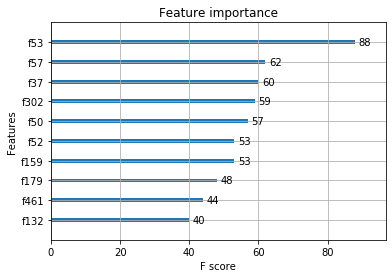

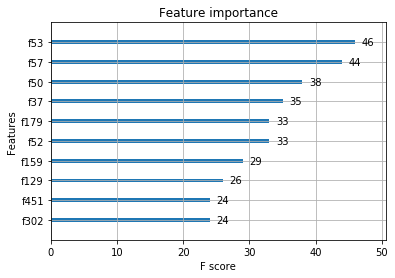

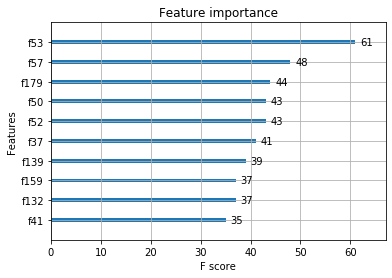

In [186]:
import xgboost

xgboost.plot_importance(paramentrs_best_3_models[0], max_num_features = 10)
xgboost.plot_importance(paramentrs_best_3_models[1], max_num_features = 10)
xgboost.plot_importance(paramentrs_best_3_models[2], max_num_features = 10)

Вывод: Самые важными являются признаки №53 (всегда на первом месте) и № 57(на втором)

Проделаем аналогичное с помощью нативного интерфейса xgboost

In [219]:
# нужно перейти к нативному использованию

from collections import Counter
from xgboost import DMatrix

params = {key: value for key, value in xgb_best_model.get_params().items() if value != None}
params["num_class"]= 7
print(params)

xgtrain = DMatrix(X_train, label=y_train)
xgtest = DMatrix(X_train, label=y_train)

bst = xgb.train(params, xgtrain, num_boost_round=100)

In [222]:
# Важность признаков
fstrs = bst.get_fscore()

for name, value in Counter(bst.get_fscore()).most_common()[:10]:
    print("{}\t{}".format(name, value))

f57	63
f53	61
f37	55
f302	53
f52	51
f159	44
f179	40
f50	38
f461	38
f41	33


#### `shap`

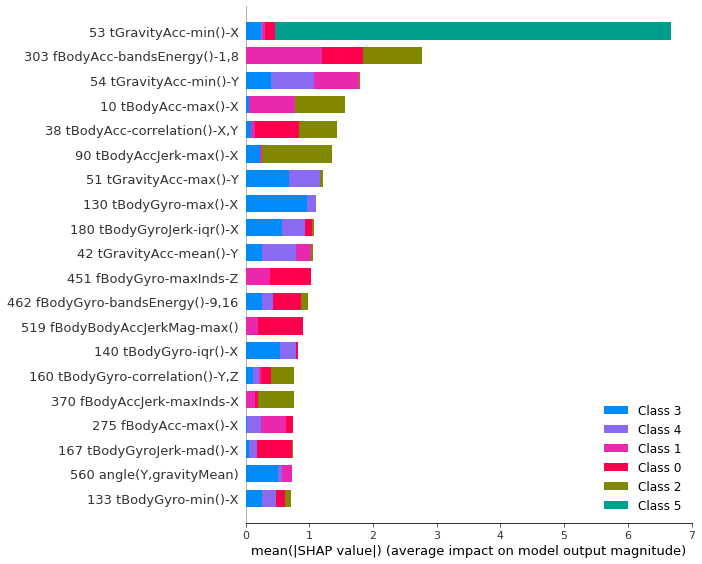

In [225]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(paramentrs_best_3_models[0])
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X, feature_names = features_name)

посмотрим на зависимости 

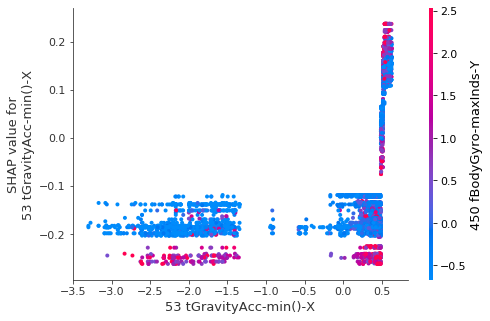

In [232]:
shap.initjs()
shap.dependence_plot('53 tGravityAcc-min()-X', shap_values[0], X_train, features_name)

**Вывод:** Наиболее важными оказались признаки под номерами `53(tGravirtAcc)` и `57(fBodyAcc-bandsEnergy)`. Думаю, разобравшись с тем как проводились эксперименты, можно понять почему эти признаки играли важнейшую роль.

# Замечание

- я не стал использовать `pca` осознанно (работал с `X_train\...` без применения pca) потому, что а) заметил что качество модели становится сильно хуже(справедливо, потому что мы уменьшили количество фичей в 3 раза, оставив только уникальные)

- я не стал строить `roc-кривую` для всех моделей, а сделал только в одном месте потому что графики выглядел не очень информативно(и были везде одинаковыми). Потому как наша roc кривая приближается к горизонательной прямой мы можем делать вывод что наши классификаторы работают "хорошо".

# Дополнение

Сначала немного не так понял условие и расмотрел все три библиотеки для бустинга, не хочется убирать)

### lightgbm

In [ ]:
skf = StratifiedKFold(n_splits = 5)
skf.split(X_train, y_train)

clf = lgb.LGBMClassifier(boosting_type = 'gbdt',
                         objective = 'multiclass',
                         num_class = 6,
                         metric = 'multi_logloss')

params = {'num_leaves': np.arange(25, 41, 5),
          'colsample_bytree' : [0.3, 0.2],
          'boosting_type':['gbdt'],
          'subsample' : [0.7],
         }

search_ = GridSearchCV(clf, param_grid = params, cv = skf)

In [ ]:
%%time
search.fit(X_train, y_train);

In [ ]:
best_lightgbm_clf = search.best_estimator_

In [ ]:
predictions_test = best_lightgbm_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, predictions_test)

print("Accuracy score on test : {}".format(test_accuracy))

In [ ]:
### Важность признаков lightgbm
import lightgbm

lightgbm.plot_importance(best_lightgbm_clf)

### catboost

In [ ]:
from catboost import CatBoostClassifier


# задаем пространство поиска
param_distributions = {
    'n_estimators' : np.arange(1, 200),
    'max_depth' : list(range(3, 8)),
    'learning_rate' : np.linspace(0.01, 0.8, 1000),
    'min_data_in_leaf' : np.arange(1, 7),
    'l2_leaf_reg' : np.linspace(0, 10, 101),
    'rsm' : np.linspace(0.5, 1, 100)
}


# определяем поиск по сетке 
catboost_clf = RandomizedSearchCV(
    estimator=CatBoostClassifier(#cat_features=text_features, 
                                 verbose=1000),
    param_distributions=param_distributions,
    scoring='accuracy',
    n_iter=30,
    n_jobs=-1,
    cv=5,
    verbose=10,
    error_score='raise'
)

In [ ]:
%%time

catboost_clf.fit(X_train, y_train)

In [ ]:
catboost_best = catboost_clf.best_estimator_

In [ ]:
accuracy_score(catboost_clf.predict(X_test), y_test)

#### catboost визуализация

In [ ]:
cb = CatBoostClassifier(silent=True)
cb.fit(X_train_pca, y_train, 
       #eval_set=[(X_test, y_test), (X_test, y_test)], 
       plot=True)

#### Важность признаков catboost

In [ ]:
cb = catboost_clf.best_estimator_
cb.fit(X_train, y_train)

for value, name in sorted(
    zip(cb.get_feature_importance(fstr_type="FeatureImportance"), 
        range(int(max(y)))), 
    reverse=True
):
    print("name {} : value{}".format(name, value))

In [ ]:
#### другой способ перебора по сетке

from bayes import get_best_params

search_space = [
    {'name': 'learning_rate', 'type':'continious', 'domain': (0.03, 0.3)},
    {'name': 'dept', 'type':'descrete', 'domain': (3, 7)}, 
    {'name': 'rsm',  'type':'continious', 'domain': (0.3, 1.0)},
    {'name': 'l2_leaf_reg',  'type':'continious', 'domain': (0.05, 1000)},
]

best_params_bayes = get_best_params(search_space, X_train, y_train)

#### other

In [242]:
# ну а еще shap умеет вот так, но нам не нужно

shap.force_plot(explainer.expected_value[0], np.array(shap_values)[0,:][0], pd.DataFrame(X).iloc[0,:], features_name)